<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting West Nile Virus in Mosquitoes

In [228]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, RocCurveDisplay, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
import re
import datetime
import random
import pickle
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import dates, cm
from geopy.distance import geodesic
from imblearn.over_sampling import SMOTENC

pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None  # default='warn'

# Read in data files

In [229]:
train = pd.read_csv('assets/processed_data/train_processed.csv')
train.head(2)

,Species,month,wnv_density,spray_indicator,avg_temp,avg_dewpt,avg_wetbulb,tot_precip,avg_windspeed,WnvPresent
0,CULEX PIPIENS/RESTUANS,5,8,0,63.4375,44.375,53.410714,1.52,10.2875,0
1,CULEX RESTUANS,5,8,0,63.4375,44.375,53.410714,1.52,10.2875,0


In [230]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Species          10506 non-null  object 
 1   month            10506 non-null  int64  
 2   wnv_density      10506 non-null  int64  
 3   spray_indicator  10506 non-null  int64  
 4   avg_temp         10506 non-null  float64
 5   avg_dewpt        10506 non-null  float64
 6   avg_wetbulb      10506 non-null  float64
 7   tot_precip       10506 non-null  float64
 8   avg_windspeed    10506 non-null  float64
 9   WnvPresent       10506 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 820.9+ KB


# Baseline Score

In [231]:
train.WnvPresent.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [232]:
roc_auc_score(y_true=train.WnvPresent, y_score=np.ones(len(train)))

0.5

The baseline AUROC would be 0.5 if one were to classify everything as 0.

# One hot encoding

In [233]:
train = pd.get_dummies(train, columns=['Species', 'month'])

In [234]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   wnv_density                     10506 non-null  int64  
 1   spray_indicator                 10506 non-null  int64  
 2   avg_temp                        10506 non-null  float64
 3   avg_dewpt                       10506 non-null  float64
 4   avg_wetbulb                     10506 non-null  float64
 5   tot_precip                      10506 non-null  float64
 6   avg_windspeed                   10506 non-null  float64
 7   WnvPresent                      10506 non-null  int64  
 8   Species_CULEX ERRATICUS         10506 non-null  uint8  
 9   Species_CULEX PIPIENS           10506 non-null  uint8  
 10  Species_CULEX PIPIENS/RESTUANS  10506 non-null  uint8  
 11  Species_CULEX RESTUANS          10506 non-null  uint8  
 12  Species_CULEX SALINARIUS        

# Further EDA

<AxesSubplot:>

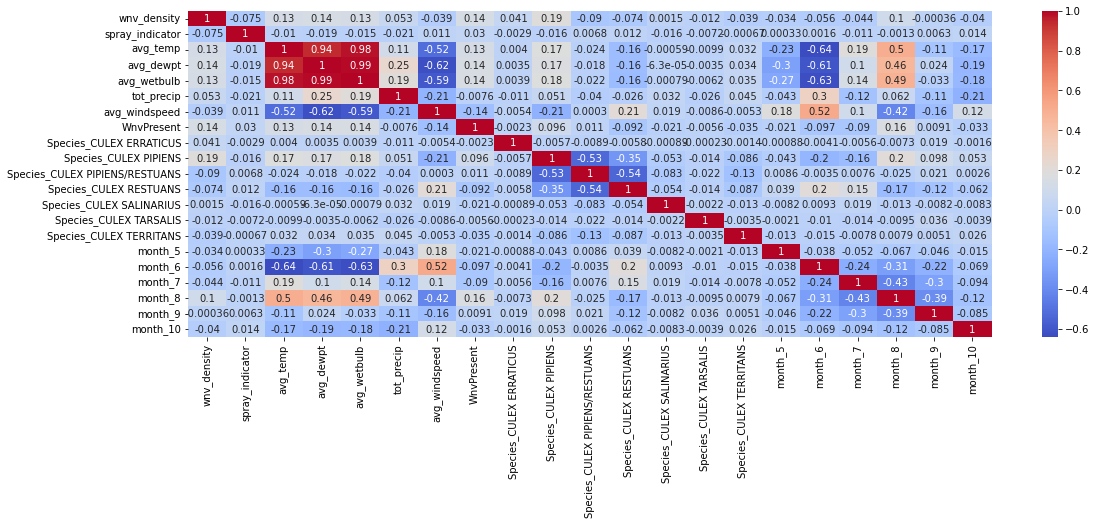

In [235]:
plt.figure(figsize=(18,6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

Unfortunately, the presence of the virus does not correlate with any of our variables. Additionally, temperature, dewpoint and wetbulb has almost perfect correlation. Because of this, we will only retain temperature.

We will also drop month_5 as this the test set does not have data for May.

In [236]:
train.drop(columns=['avg_dewpt', 'avg_wetbulb', 'month_5'], inplace=True)

# Modelling

In [237]:
X = train.drop(columns=['WnvPresent'])
y = train['WnvPresent']

In [263]:
X.head(1)

,wnv_density,spray_indicator,avg_temp,tot_precip,avg_windspeed,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,month_6,month_7,month_8,month_9,month_10
0,8,0,63.4375,1.52,10.2875,0,0,1,0,0,0,0,0,0,0,0,0


In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [239]:
def fit_and_plot(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    '''
    This function takes in a model, train and test dataframes and outputs 4 things:
    1. The AUC score on the train dataset
    2. The AUC score on the test dataset
    3. The confusion matrix on the test dataset
    4. The ROC on the test dataset
    '''
    
    print(f'-----FITTING FOR {model}...-----')
    model.fit(X_train, y_train)
    
    train_probs = model.predict_proba(X_train)[:,1]
    test_probs = model.predict_proba(X_test)[:,1]
    
    train_score = round(roc_auc_score(y_true=y_train, y_score=train_probs),4)
    print(f'Training ROC AUC score: {train_score}')
    
    test_score = round(roc_auc_score(y_true=y_test, y_score=test_probs),4)
    print(f'Test ROC AUC score: {test_score}')
    
    cm = confusion_matrix(y_test, model.predict(X_test), labels=model.classes_)
    
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), constrained_layout=True)
    
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot(ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    plot_roc_curve(model, X_test, y_test, ax=ax[1])
    ax[1].set_title('Area under ROC')

In [240]:
# Instantiate 4 different models

mlp = MLPClassifier((8,8,8,8))
lr = LogisticRegression()
rf = RandomForestClassifier(max_depth=5)
ada = AdaBoostClassifier()

-----FITTING FOR MLPClassifier(hidden_layer_sizes=(8, 8, 8, 8))...-----
Training ROC AUC score: 0.8714
Test ROC AUC score: 0.8547


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


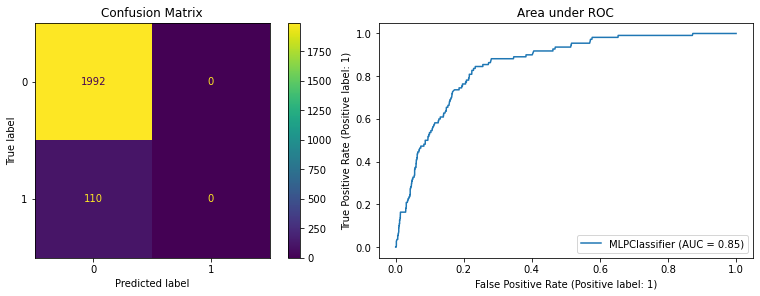

In [241]:
fit_and_plot(mlp)

-----FITTING FOR LogisticRegression()...-----
Training ROC AUC score: 0.8073
Test ROC AUC score: 0.7788


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


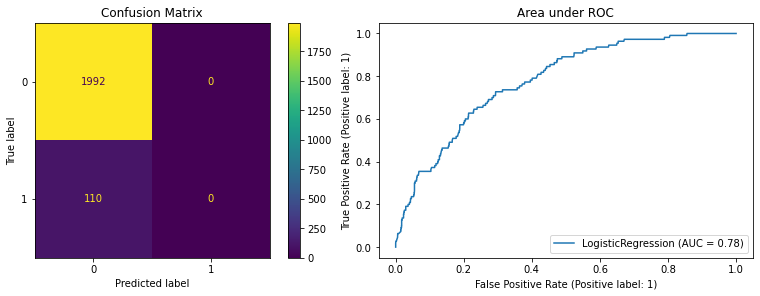

In [242]:
fit_and_plot(lr)

-----FITTING FOR AdaBoostClassifier()...-----
Training ROC AUC score: 0.898
Test ROC AUC score: 0.8843


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


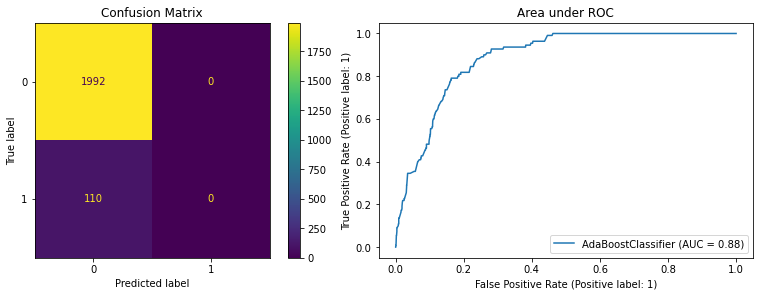

In [243]:
fit_and_plot(ada)

-----FITTING FOR RandomForestClassifier(max_depth=5)...-----
Training ROC AUC score: 0.8929
Test ROC AUC score: 0.871


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


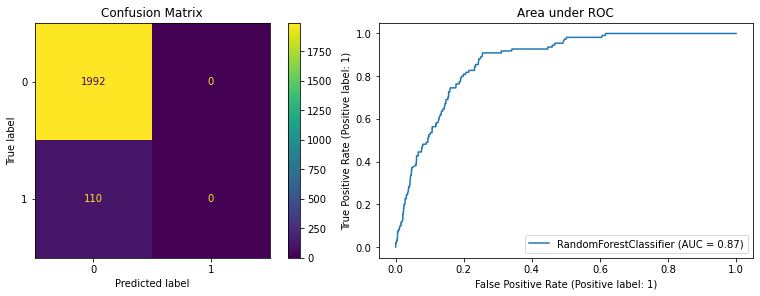

In [244]:
fit_and_plot(rf)

While RandomForest and AdaBoostClassifier seem to have similar AUC score, we see that RF has simply predicted everything as 0. We will try to tune AdaBoost further.

# Tune hyperparameters for AdaBoostClassifier

In [245]:
rf1 = RandomForestClassifier(n_estimators=150, max_depth=5, class_weight='balanced_subsample')
rf2 = RandomForestClassifier(n_estimators=200, max_depth=7, class_weight='balanced_subsample', ccp_alpha=1.0)
rf3 = RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced_subsample', ccp_alpha=10.0)

params = {
    'base_estimator': [None, rf1, rf2, rf3],
    'n_estimators': [50,100],
    'learning_rate': [1.0, 0.1]
}

gs = GridSearchCV(ada, param_grid = params, verbose=1, scoring='roc_auc')

In [246]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=50; total time=   0.0s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=50; total time=   0.0s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=50; total time=   0.0s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=50; total time=   0.0s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=50; total time=   0.0s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=100; total time=   0.2s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=100; total time=   0.2s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=100; total time=   0.2s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=100; total time=   0.2s
[CV] END base_estimator=None, learning_rate=1.0, n_estimators=100; total time=   0.2s
[CV] END base_estimator=None, learning_rate=0.1, n_estimators=50; total time=   0.0s

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [None,
                                            RandomForestClassifier(class_weight='balanced_subsample',
                                                                   max_depth=5,
                                                                   n_estimators=150),
                                            RandomForestClassifier(ccp_alpha=1.0,
                                                                   class_weight='balanced_subsample',
                                                                   max_depth=7,
                                                                   n_estimators=200),
                                            RandomForestClassifier(ccp_alpha=10.0,
                                                                   class_weight='balanced_subsample',
                                                                   max_depth=10,
                     

In [247]:
gs.best_score_

0.8889655044600586

In [248]:
gs.best_params_

{'base_estimator': RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                        n_estimators=150),
 'learning_rate': 0.1,
 'n_estimators': 100}

# Refit using best parameters of AdaBoostClassifier

In [260]:
ada_final = AdaBoostClassifier(base_estimator=rf1,
                              n_estimators=100,
                              learning_rate=0.1)

-----FITTING FOR AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                         max_depth=5,
                                                         n_estimators=150),
                   learning_rate=0.1, n_estimators=100)...-----
Training ROC AUC score: 0.9288
Test ROC AUC score: 0.8855


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


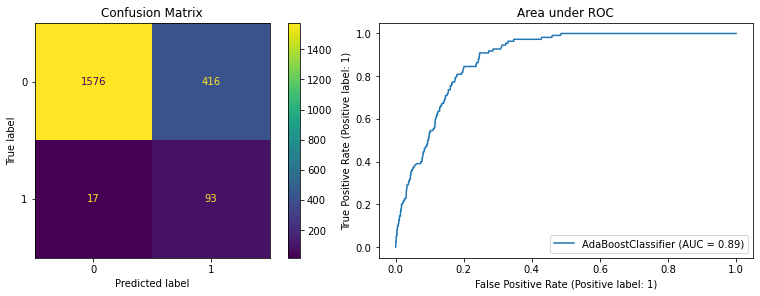

In [261]:
fit_and_plot(ada_final)

The tuned model has a better training score but the same test score and AUC score. However we see that it is now able to pick out the positive cases, albeit at the cost of more false positives. We believe that from a public health perspective, it is better to have more false positives than false negatives as the consequences of a outbreak is far more severe than that of wasting sprays.

Hence, though the AUC score is similar, the tuned model is considered better than the untuned one.

In [262]:
# save model
pickle.dump(ada_final, open('models/adaboost_tuned.sav', 'wb'))

# Learning from the model

In [274]:
feature_df = pd.DataFrame({'feature': ada_final.feature_names_in_,
                          'importance': ada_final.feature_importances_})

<AxesSubplot:xlabel='importance', ylabel='feature'>

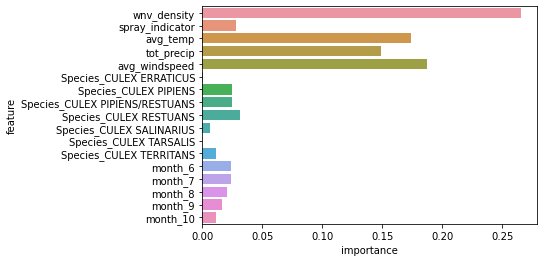

In [275]:
sns.barplot(data=feature_df, y='feature', x='importance', orient='h')

We see that WNV density is the most important predictor, followed by weather conditions. For species, the Pipiens and Restuans subspecies are also more important than the other subspecies, corroborating what we observed in the EDA where only these 2 species carried the virus. 

Interestingly, the relative importances of the months does not follow the patterns of positivity observed during EDA. Here, June and July are the most important months while in EDA, Jul-Sep are the most important. Nevertheless, these importances are insignificant compared to the other features.

# Experimenting with oversampling with SMOTE

In [256]:
smotenc = SMOTENC([5,6,7,8,9,10,11,12,13,14,15,16],random_state = 101)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

In [257]:
ada_final = pickle.load(open('models/adaboost_tuned.sav', 'rb'))

-----FITTING FOR AdaBoostClassifier(base_estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                         max_depth=5,
                                                         n_estimators=150),
                   learning_rate=0.1, n_estimators=100)...-----
Training ROC AUC score: 0.9589
Test ROC AUC score: 0.8646


C:\HA\Python\Anaconda\envs\geoenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


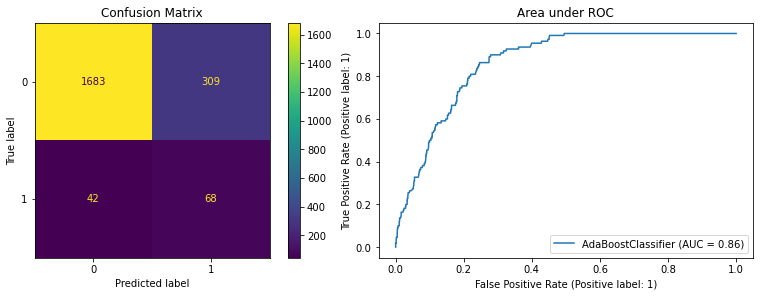

In [258]:
fit_and_plot(ada_final, X_oversample, y_oversample, X_test, y_test)

Although the AUC train score is higher, the test score has decreased, indicating some kind of overfitting. We thus conclude that SMOTE oversampling does not help in our performance, hence we will not employ oversampling.